In [ ]:
import pandas as pd
import re
import numpy as np

def parse_graph_info_file(txt_path):
    records = []
    with open(txt_path, 'r') as f:
        current_difficulty = None
        for line in f:
            line = line.strip()
            # Detect difficulty section headers
            m = re.match(r'^(easy|medium|hard): \d+ file', line)
            if m:
                current_difficulty = m.group(1)
            # Detect entries with path and score
            else:
                m2 = re.match(r'^(.*?)\s*\(score:\s*([\d.]+)\)', line)
                if m2 and current_difficulty:
                    path = m2.group(1).strip()
                    score = float(m2.group(2))
                    records.append({
                        'file_path': path,
                        'difficulty': current_difficulty,
                        'complexity': score
                    })
    return pd.DataFrame(records)

# Parse the three files
full = parse_graph_info_file('../src/graph_complexity_info_3493.txt')
cand = parse_graph_info_file('../src/graph_complexity_info_666.txt')
sample = parse_graph_info_file('../src/graph_complexity_info_69.txt')

# 1) Retain only easy/medium from the existing sample (drop hard)
full_keep = full[full['difficulty'].isin(['easy', 'medium'])]
print("======== Full Dataset Statistics: ========")
print("full_keep shape:", full_keep.shape)
print("Existing full counts:\n", full_keep['difficulty'].value_counts())

print("======== Sample Dataset Statistics: ========")
sample_keep = sample[sample['difficulty'].isin(['easy', 'medium'])]
print("sample_keep shape:", sample_keep.shape)

# 2) Compute existing counts
counts = sample_keep['difficulty'].value_counts()
print("Existing sample counts:\n", counts)

# 3) Cohen's d between full and existing sample
def cohens_d(a, b):
    nx, ny = len(a), len(b)
    mean_diff = a.mean() - b.mean()
    varx = a.var(ddof=1)
    vary = b.var(ddof=1)

    pooled_sd = np.sqrt(((nx-1)*varx + (ny-1)*vary) / (nx+ny-2))
    return mean_diff / pooled_sd

print("============= After dropping hard =============")
print("Number of Full Dataset: ", len(full_keep['complexity']))
print("Number of Sample Dataset: ", len(sample_keep['complexity']))

d_initial = cohens_d(full_keep['complexity'], sample_keep['complexity'])
print("\nInitial Cohen's d:", d_initial)

# 4) Determine how many more easy/medium are needed
needed_easy = max(0, 50 - counts.get('easy', 0))
needed_medium = max(0, 64 - counts.get('medium', 0))
print("=========================================")
print(f"Need additional: {needed_easy} easy; {needed_medium} medium")

# 5) Filter candidate pool (exclude already kept)
cand_filtered = cand[~cand['file_path'].isin(sample_keep['file_path'])]
cand_easy = cand_filtered[cand_filtered['difficulty']=='easy']
cand_med  = cand_filtered[cand_filtered['difficulty']=='medium']

# 6) Sort candidates by closeness to full dataset mean complexity
full_mean = full_keep['complexity'].mean()
cand_easy = cand_easy.assign(dist=(cand_easy['complexity'] - full_mean).abs())\
                     .sort_values('dist')
cand_med  = cand_med.assign(dist=(cand_med['complexity']  - full_mean).abs())\
                    .sort_values('dist')

# 7) Greedy selection to best reduce Cohen's d, stopping early if |d|<0.2
remaining = pd.concat([cand_easy, cand_med])
current   = sample_keep.copy()
selected  = pd.DataFrame(columns=current.columns)
stop_flag = False

for diff, needed in [('easy', needed_easy), ('medium', needed_medium)]:
    for _ in range(needed):
        # compute current d and stop if already below threshold
        curr_d = abs(cohens_d(full_keep['complexity'], current['complexity']))
        if curr_d < 0.2:
            print(f"Stopping early: |d|={curr_d:.4f} < 0.2")
            stop_flag = True
            break

        best_idx = None
        best_d   = curr_d

        # try each remaining candidate of this difficulty
        for idx, row in remaining[remaining['difficulty']==diff].iterrows():
            trial = pd.concat([current, pd.DataFrame([row])], ignore_index=True)
            d = abs(cohens_d(full_keep['complexity'], trial['complexity']))
            if d < best_d:
                best_d, best_idx = d, idx

        if best_idx is None:
            print(f"No more {diff} files improve Cohen's d; stopping.")
            stop_flag = True
            break

        # add the best one to current & to selected
        best_row  = remaining.loc[[best_idx]]
        current   = pd.concat([current,  best_row], ignore_index=True)
        selected  = pd.concat([selected, best_row], ignore_index=True)
        remaining = remaining.drop(best_idx)

        # check again after adding
        if best_d < 0.2:
            print(f"Reached |d|={best_d:.4f} < 0.2; stopping early.")
            stop_flag = True
            break

    if stop_flag:
        break

# 8) Output the directories of the selected entries
print("\nSelected directories to add:")
num = 1
for path in selected['file_path']:
    print(num, ": ", path.rsplit('/', 1)[0])
    num += 1

# 9) Verify new Cohen's d
new_sample = pd.concat([sample_keep, selected], ignore_index=True)
d_new = cohens_d(full_keep['complexity'], new_sample['complexity'])
a =full_keep['complexity']
b = new_sample['complexity']
nx, ny = len(a), len(b)
mean_diff = a.mean() - b.mean()
varx = a.var(ddof=1)
vary = b.var(ddof=1)
print("\n================= Data Statistics:================")
print("\nFull Data Statistics:")
print(f"  Count: {nx}")
print(f"  Mean: {a.mean():.4f}")
print(f"  Variance: {varx:.4f}")

print("\nSample Data Statistics:")
print(f"  Count: {ny}")
print(f"  Mean: {b.mean():.4f}")
print(f"  Variance: {vary:.4f}")
print("\nNew Cohen's d:", d_new)


In [15]:
import pandas as pd
import re
import numpy as np

def parse_graph_info_file(txt_path):
    records = []
    with open(txt_path, 'r') as f:
        current_difficulty = None
        for line in f:
            line = line.strip()
            # Detect difficulty section headers
            m = re.match(r'^(easy|medium|hard): \d+ file', line)
            if m:
                current_difficulty = m.group(1)
            # Detect entries with path and score
            else:
                m2 = re.match(r'^(.*?)\s*\(score:\s*([\d.]+)\)', line)
                if m2 and current_difficulty:
                    path = m2.group(1).strip()
                    score = float(m2.group(2))
                    records.append({
                        'file_path': path,
                        'difficulty': current_difficulty,
                        'complexity': score
                    })
    return pd.DataFrame(records)

# Parse the three files
full   = parse_graph_info_file('../src/graph_complexity_info_3493.txt')
cand   = parse_graph_info_file('../src/graph_complexity_info_662.txt')
sample = parse_graph_info_file('../src/graph_complexity_info_69.txt')

# 1) Retain only easy/medium from the existing sample (drop hard)
full_keep   = full[ full['difficulty'].isin(['easy','medium']) ]
print("======== Full Dataset Statistics: ========")
print("full_keep shape:", full_keep.shape)
print("Existing full counts:\n", full_keep['difficulty'].value_counts())

print("======== Candidate Dataset Statistics: ========")
print("cand shape:", cand.shape)
print("Existing cand counts:\n", cand['difficulty'].value_counts())

print("======== Sample Dataset Statistics: ========")
sample_keep = sample[ sample['difficulty'].isin(['easy','medium']) ]
print("sample_keep shape:", sample_keep.shape)

# 2) Compute existing counts
counts = sample_keep['difficulty'].value_counts()
print("Existing sample counts:\n", counts)

# 3) Cohen's d between full and existing sample
def cohens_d(a, b):
    nx, ny    = len(a), len(b)
    mean_diff = a.mean() - b.mean()
    varx      = a.var(ddof=1)
    vary      = b.var(ddof=1)
    pooled_sd = np.sqrt(((nx-1)*varx + (ny-1)*vary) / (nx+ny-2))
    return mean_diff / pooled_sd

print("============= After dropping hard =============")
print("Number of Full Dataset: ", len(full_keep['complexity']))
print("Number of Sample Dataset: ", len(sample_keep['complexity']))

d_initial = cohens_d(full_keep['complexity'], sample_keep['complexity'])
print("\nInitial Cohen's d:", d_initial)

# 4) Determine how many more easy/medium are needed
needed_easy   = max(0, 50 - counts.get('easy',   0))
needed_medium = max(0, 64 - counts.get('medium', 0))
print("=========================================")
print(f"Need additional: {needed_easy} easy; {needed_medium} medium")

# 5) Filter candidate pool (exclude already kept)
cand_filtered = cand[~cand['file_path'].isin(sample_keep['file_path'])]
cand_easy     = cand_filtered[cand_filtered['difficulty']=='easy']
cand_med      = cand_filtered[cand_filtered['difficulty']=='medium']

# 6) Sort candidates by closeness to full dataset mean complexity
full_mean  = full_keep['complexity'].mean()
cand_easy  = cand_easy.assign(dist=(cand_easy['complexity'] - full_mean).abs())\
                     .sort_values('dist')
cand_med   = cand_med.assign(dist=(cand_med['complexity'] - full_mean).abs())\
                    .sort_values('dist')

# 7) Greedy selection to best reduce Cohen's d, BUT fill all quotas
remaining = pd.concat([cand_easy, cand_med])
current   = sample_keep.copy()
selected  = pd.DataFrame(columns=current.columns)
stop_flag = False

for diff, needed in [('easy', needed_easy), ('medium', needed_medium)]:
    for _ in range(needed):
        # compute current d  (no longer stopping here)
        curr_d = abs(cohens_d(full_keep['complexity'], current['complexity']))
        # if curr_d < 0.2:
        #     print(f"Stopping early: |d|={curr_d:.4f} < 0.2")
        #     stop_flag = True
        #     break

        best_idx = None
        best_d   = curr_d

        # try each remaining candidate of this difficulty
        for idx, row in remaining[remaining['difficulty']==diff].iterrows():
            trial = pd.concat([current, pd.DataFrame([row])], ignore_index=True)
            d = abs(cohens_d(full_keep['complexity'], trial['complexity']))
            if d < best_d:
                best_d, best_idx = d, idx

        if best_idx is None:
            print(f"No more {diff} files improve Cohen's d; stopping.")
            stop_flag = True
            break

        # add the best one to current & to selected
        best_row  = remaining.loc[[best_idx]]
        current   = pd.concat([current,  best_row], ignore_index=True)
        selected  = pd.concat([selected, best_row],  ignore_index=True)
        remaining = remaining.drop(best_idx)

        # check again after adding  (but do NOT break)
        # if best_d < 0.2:
        #     print(f"Reached |d|={best_d:.4f} < 0.2; but continuing to fill quotas.")
        #     stop_flag = True
        #     break

    if stop_flag:
        break

# 8) Output the directories of the selected entries
print("\nSelected directories to add:")
num = 1
for path in selected['file_path']:
    print(num, ": ", path.rsplit('/',1)[0])
    num += 1

# 9) Verify new Cohen's d
new_sample = pd.concat([sample_keep, selected], ignore_index=True)
d_new      = cohens_d(full_keep['complexity'], new_sample['complexity'])
a = full_keep['complexity']
b = new_sample['complexity']
nx, ny = len(a), len(b)
mean_diff = a.mean() - b.mean()
varx      = a.var(ddof=1)
vary      = b.var(ddof=1)

print("\n================= Data Statistics:================")
print("\nFull Data Statistics:")
print(f"  Count: {nx}")
print(f"  Mean: {a.mean():.4f}")
print(f"  Variance: {varx:.4f}")

print("\nSample Data Statistics:")
print(f"  Count: {ny}")
print(f"  Mean: {b.mean():.4f}")
print(f"  Variance: {vary:.4f}")
print("\nNew Cohen's d:", d_new)


======== Full Dataset Statistics: ========
full_keep shape: (3486, 3)
Existing full counts:
 difficulty
medium    1958
easy      1528
Name: count, dtype: int64
======== Candidate Dataset Statistics: ========
cand shape: (662, 3)
Existing cand counts:
 difficulty
medium    431
easy      227
hard        4
Name: count, dtype: int64
======== Sample Dataset Statistics: ========
sample_keep shape: (68, 3)
Existing sample counts:
 difficulty
easy      34
medium    34
Name: count, dtype: int64
============= After dropping hard =============
Number of Full Dataset:  3486
Number of Sample Dataset:  68

Initial Cohen's d: 0.48347261079009923
Need additional: 16 easy; 30 medium
No more medium files improve Cohen's d; stopping.

Selected directories to add:
1 :  ../cubicasa5k-666/high_quality_architectural/12482
2 :  ../cubicasa5k-666/high_quality_architectural/11008
3 :  ../cubicasa5k-666/high_quality_architectural/11016
4 :  ../cubicasa5k-666/high_quality_architectural/11004
5 :  ../cubicasa5k-66

## Just sample without considering previous samples

In [17]:
import pandas as pd
import re
import numpy as np

def parse_graph_info_file(txt_path):
    records = []
    with open(txt_path, 'r') as f:
        current_difficulty = None
        for line in f:
            line = line.strip()
            # Detect difficulty section headers
            m = re.match(r'^(easy|medium|hard): \d+ file', line)
            if m:
                current_difficulty = m.group(1)
            # Detect entries with path and score
            else:
                m2 = re.match(r'^(.*?)\s*\(score:\s*([\d.]+)\)', line)
                if m2 and current_difficulty:
                    path = m2.group(1).strip()
                    score = float(m2.group(2))
                    records.append({
                        'file_path': path,
                        'difficulty': current_difficulty,
                        'complexity': score
                    })
    return pd.DataFrame(records)

# Parse the full and candidate files
full = parse_graph_info_file('../src/graph_complexity_info_3493.txt')
cand = parse_graph_info_file('../src/graph_complexity_info_650.txt')
# sample = parse_graph_info_file('../src/graph_complexity_info_69.txt')  # ignored

# 1) Retain only easy/medium in the full dataset (for reference)
full_keep = full[full['difficulty'].isin(['easy', 'medium'])]
print("======== Full Dataset Statistics: ========")
print("full_keep shape:", full_keep.shape)
print("Existing full counts:\n", full_keep['difficulty'].value_counts())

# 2) Set quotas
quota_easy  = 50
quota_medium = 64
print("=========================================")
print(f"Quota: {quota_easy} easy; {quota_medium} medium")

# 3) Filter candidate pool (ignore previously sampled)
cand_keep = cand[cand['difficulty'].isin(['easy', 'medium'])]
cand_easy = cand_keep[cand_keep['difficulty']=='easy']
cand_med  = cand_keep[cand_keep['difficulty']=='medium']

# 4) Compute full‐data mean complexity
full_mean = full_keep['complexity'].mean()

# 5) Sort candidates by closeness to full mean and pick top quotas
cand_easy = cand_easy.assign(dist=(cand_easy['complexity'] - full_mean).abs())\
                     .sort_values('dist')
cand_med  = cand_med.assign(dist=(cand_med['complexity']  - full_mean).abs())\
                    .sort_values('dist')
selected_easy = cand_easy.head(quota_easy)
selected_med  = cand_med.head(quota_medium)
selected      = pd.concat([selected_easy, selected_med], ignore_index=True)
print("Selected counts:\n", selected['difficulty'].value_counts())

# 6) Cohen's d between full and new sample
def cohens_d(a, b):
    nx, ny    = len(a), len(b)
    mean_diff = a.mean() - b.mean()
    varx      = a.var(ddof=1)
    vary      = b.var(ddof=1)
    print("\n================= Data Statistics:================")
    print("\nFull Data Statistics:")
    print(f"  Count: {nx}")
    print(f"  Mean: {a.mean():.4f}")
    print(f"  Variance: {varx:.4f}")

    print("\nSample Data Statistics:")
    print(f"  Count: {ny}")
    print(f"  Mean: {b.mean():.4f}")
    print(f"  Variance: {vary:.4f}")

    pooled_sd = np.sqrt(((nx-1)*varx + (ny-1)*vary) / (nx+ny-2))
    return mean_diff / pooled_sd

d = cohens_d(full_keep['complexity'], selected['complexity'])
print("Sample size:", len(selected))
print("Cohen's d:", d)

# 7) Output the directories of the selected entries
print("\nSelected directories to add:")
num = 1
for path in selected['file_path']:
    print(num, ": ", path.rsplit('/', 1)[0])
    num +=1 


======== Full Dataset Statistics: ========
full_keep shape: (3486, 3)
Existing full counts:
 difficulty
medium    1958
easy      1528
Name: count, dtype: int64
Quota: 50 easy; 64 medium
Selected counts:
 difficulty
medium    64
easy      50
Name: count, dtype: int64

================= Data Statistics:================

Full Data Statistics:
  Count: 3486
  Mean: 0.3510
  Variance: 0.0089

Sample Data Statistics:
  Count: 114
  Mean: 0.3388
  Variance: 0.0002
Sample size: 114
Cohen's d: 0.13117234537514552

Selected directories to add:
1 :  ../cubicasa5k-3493-cubigraph/high_quality_architectural/12906
2 :  ../cubicasa5k-3493-cubigraph/high_quality/11944
3 :  ../cubicasa5k-3493-cubigraph/high_quality/12980
4 :  ../cubicasa5k-3493-cubigraph/high_quality/397
5 :  ../cubicasa5k-3493-cubigraph/high_quality_architectural/12878
6 :  ../cubicasa5k-3493-cubigraph/high_quality_architectural/11566
7 :  ../cubicasa5k-3493-cubigraph/high_quality/3733
8 :  ../cubicasa5k-3493-cubigraph/high_quality_arc

## Consider Data distribution

In [87]:
import pandas as pd
import re
import numpy as np

def parse_graph_info_file(txt_path):
    """
    Parse a text file where sections are marked by difficulty headers like
      easy: 1528 file
      medium: 1958 file
    and entries under each header look like:
      path/to/file.svg (score: 0.1234)
    Returns a DataFrame with columns ['file_path', 'difficulty', 'complexity'].
    """
    records = []
    with open(txt_path, 'r') as f:
        current_difficulty = None
        for line in f:
            line = line.strip()
            # Detect difficulty section headers
            m = re.match(r'^(easy|medium|hard): \d+ file', line)
            if m:
                current_difficulty = m.group(1)
            else:
                # Detect entries with path and score
                m2 = re.match(r'^(.*?)\s*\(score:\s*([\d.]+)\)', line)
                if m2 and current_difficulty:
                    path = m2.group(1).strip()
                    score = float(m2.group(2))
                    records.append({
                        'file_path': path,
                        'difficulty': current_difficulty,
                        'complexity': score
                    })
    return pd.DataFrame(records)

# -------------------------------------------------------------------------
# 1) Parse the full dataset and the candidate pool
full = parse_graph_info_file('../src/graph_complexity_info_3493.txt')
cand = parse_graph_info_file('../src/graph_complexity_info_650.txt')

# Keep only easy/medium entries in the full dataset
full_keep = full[full['difficulty'].isin(['easy', 'medium'])]

# 2) Set sampling quotas
quota_easy   = 100
quota_medium = 128

# 3) Filter the candidate pool to easy/medium
cand_keep = cand[cand['difficulty'].isin(['easy', 'medium'])]
cand_easy = cand_keep[cand_keep['difficulty']=='easy'].copy()
cand_med  = cand_keep[cand_keep['difficulty']=='medium'].copy()

# 4) Compute mean complexity of the full dataset (for reference)
full_mean = full_keep['complexity'].mean()

# 5) Stratified sampling via quantile bins
bin_count = 5
full_bins = pd.qcut(full_keep['complexity'], q=bin_count, duplicates='drop')
bin_proportions = full_bins.value_counts(normalize=True).sort_index()
bins = bin_proportions.index.categories

# Assign each candidate to the same bins
cand_easy['bin'] = pd.cut(cand_easy['complexity'], bins=bins)
cand_med ['bin'] = pd.cut(cand_med ['complexity'], bins=bins)

selected_easy_list = []
selected_med_list  = []

for b in bins:
    prop = bin_proportions.get(b, 0)
    #n_easy = int(round(quota_easy * prop))
    #n_med  = int(round(quota_medium * prop))

    # Bin별 최소 샘플 수 보장
    n_easy = max(1, int(round(quota_easy * prop)))
    n_med  = max(1, int(round(quota_medium * prop)))

    group_easy = cand_easy[cand_easy['bin'] == b]
    group_med  = cand_med [cand_med ['bin'] == b]

    if n_easy > 0:
        if len(group_easy) >= n_easy:
            selected_easy_list.append(group_easy.sample(n=n_easy, random_state=42))
        else:
            selected_easy_list.append(group_easy)

    if n_med > 0:
        if len(group_med) >= n_med:
            selected_med_list.append(group_med.sample(n=n_med, random_state=42))
        else:
            selected_med_list.append(group_med)

selected_easy = pd.concat(selected_easy_list, ignore_index=True)
selected_med  = pd.concat(selected_med_list,  ignore_index=True)

# -------------------------------------------------------------------------
# 5b) Fill any shortfall by filtering on file_path (not index!)
def fill_shortfall(selected_df, cand_df, quota, seed=42):
    shortfall = quota - len(selected_df)
    if shortfall > 0:
        remaining = cand_df.loc[~cand_df['file_path'].isin(selected_df['file_path'])]
        extra = remaining.sample(n=shortfall, random_state=seed)
        selected_df = pd.concat([selected_df, extra], ignore_index=True)
    return selected_df

selected_easy = fill_shortfall(selected_easy, cand_easy, quota_easy, seed=42)
selected_med  = fill_shortfall(selected_med,  cand_med,  quota_medium, seed=42)

# Enforce uniqueness just in case
selected_easy = selected_easy.drop_duplicates(subset=['file_path']).reset_index(drop=True)
selected_med  = selected_med.drop_duplicates(subset=['file_path']).reset_index(drop=True)

# -------------------------------------------------------------------------
# 6) Compute Cohen's d between the full and the new sample
def cohens_d(a, b):
    nx, ny    = len(a), len(b)
    mean_diff = a.mean() - b.mean()
    varx      = a.var(ddof=1)
    vary      = b.var(ddof=1)

    print("\n================= Data Statistics =================")
    print("Full Data Statistics:")
    print(f"  Count: {nx}")
    print(f"  Mean:  {a.mean():.4f}")
    print(f"  Var:   {varx:.4f}")

    print("\nSample Data Statistics:")
    print(f"  Count: {ny}")
    print(f"  Mean:  {b.mean():.4f}")
    print(f"  Var:   {vary:.4f}")

    pooled_sd = np.sqrt(((nx-1)*varx + (ny-1)*vary) / (nx+ny-2))
    return mean_diff / pooled_sd

selected = pd.concat([selected_easy, selected_med], ignore_index=True)
d = cohens_d(full_keep['complexity'], selected['complexity'])
print(f"\nSample size: {len(selected)}  (should be {quota_easy + quota_medium})")
print(f"Cohen's d:   {d:.4f}")

# -------------------------------------------------------------------------
# 7) Output the selected directories
print("\n===== Easy Samples =====")
for i, row in selected_easy.iterrows():
    dir_path = row['file_path'].rsplit('/', 1)[0]
    score    = row['complexity']
    print(f"{i+1:2d}. [Easy]   {dir_path}   (score: {score:.4f})")

print("\n===== Medium Samples =====")
for i, row in selected_med.iterrows():
    dir_path = row['file_path'].rsplit('/', 1)[0]
    score    = row['complexity']
    print(f"{i+1:2d}. [Medium] {dir_path}   (score: {score:.4f})")



================= Data Statistics =================
Full Data Statistics:
  Count: 3486
  Mean:  0.3510
  Var:   0.0089

Sample Data Statistics:
  Count: 228
  Mean:  0.3347
  Var:   0.0042

Sample size: 228  (should be 228)
Cohen's d:   0.1755

===== Easy Samples =====
 1. [Easy]   ../cubicasa5k-3493-cubigraph/high_quality/11255   (score: 0.2560)
 2. [Easy]   ../cubicasa5k-3493-cubigraph/high_quality/1547   (score: 0.2665)
 3. [Easy]   ../cubicasa5k-3493-cubigraph/colorful/12200   (score: 0.2245)
 4. [Easy]   ../cubicasa5k-3493-cubigraph/high_quality/10392   (score: 0.2560)
 5. [Easy]   ../cubicasa5k-3493-cubigraph/high_quality_architectural/233   (score: 0.1600)
 6. [Easy]   ../cubicasa5k-3493-cubigraph/high_quality_architectural/11008   (score: 0.2701)
 7. [Easy]   ../cubicasa5k-3493-cubigraph/high_quality_architectural/14146   (score: 0.2771)
 8. [Easy]   ../cubicasa5k-3493-cubigraph/high_quality_architectural/11279   (score: 0.2701)
 9. [Easy]   ../cubicasa5k-3493-cubigraph/high_

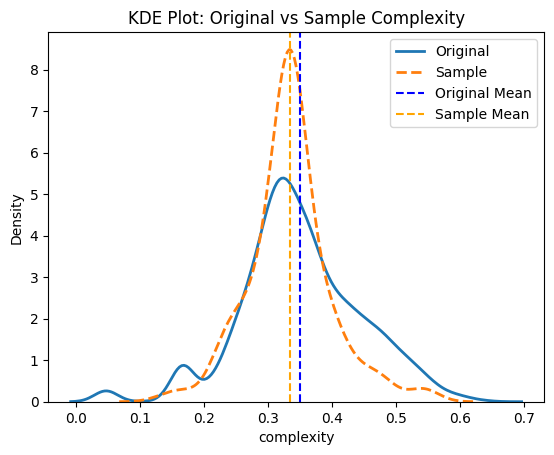

In [88]:
import seaborn as sns

sns.kdeplot(full_keep['complexity'], label="Original", linewidth=2)
sns.kdeplot(selected['complexity'], label="Sample", linestyle="--", linewidth=2)
plt.axvline(full_keep['complexity'].mean(), color='blue', linestyle='dashed', label='Original Mean')
plt.axvline(selected['complexity'].mean(), color='orange', linestyle='dashed', label='Sample Mean')
plt.legend()
plt.title("KDE Plot: Original vs Sample Complexity")
plt.show()


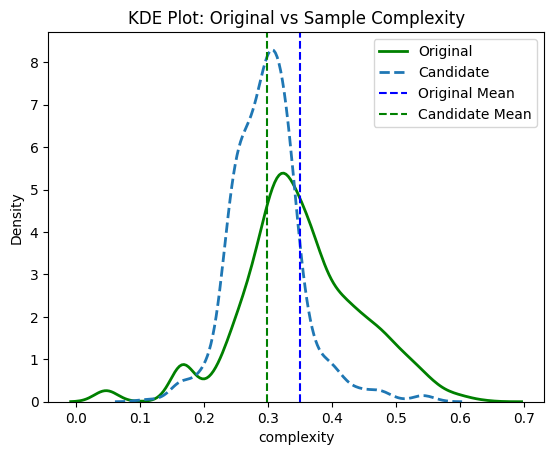

In [89]:
import seaborn as sns

sns.kdeplot(full_keep['complexity'], label="Original", linewidth=2, color='green')
sns.kdeplot(cand_keep['complexity'], label="Candidate", linestyle="--", linewidth=2)
plt.axvline(full_keep['complexity'].mean(), color='blue', linestyle='dashed', label='Original Mean')
plt.axvline(cand_keep['complexity'].mean(), color='green', linestyle='dashed', label='Candidate Mean')
plt.legend()
plt.title("KDE Plot: Original vs Sample Complexity")
plt.show()

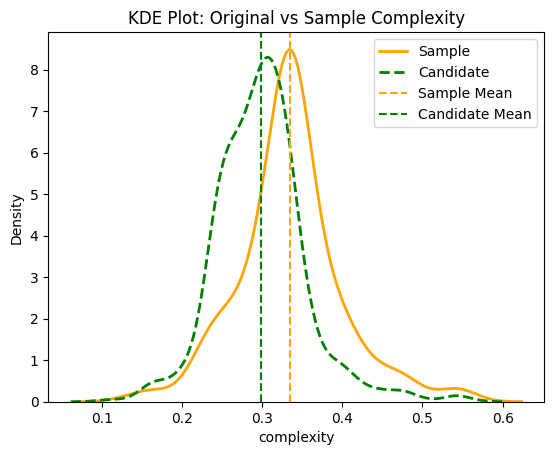

In [90]:
import seaborn as sns

sns.kdeplot(selected['complexity'], label="Sample", linewidth=2, color='orange')
sns.kdeplot(cand_keep['complexity'], label="Candidate", linestyle="--", linewidth=2, color='green')
plt.axvline(selected['complexity'].mean(), color='orange', linestyle='dashed', label='Sample Mean')
plt.axvline(cand_keep['complexity'].mean(), color='green', linestyle='dashed', label='Candidate Mean')
plt.legend()
plt.title("KDE Plot: Original vs Sample Complexity")
plt.show()

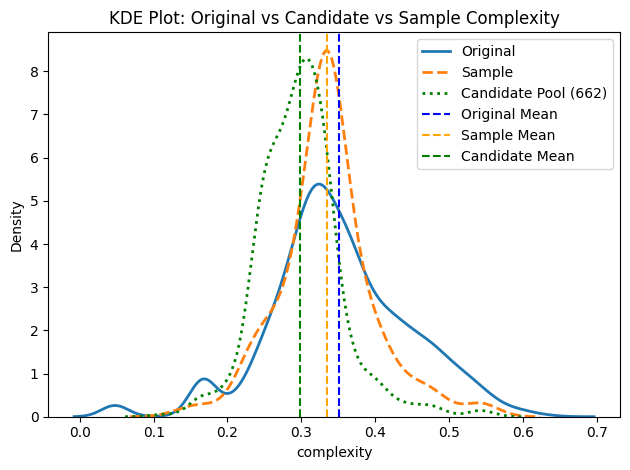

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(full_keep['complexity'], label="Original", linewidth=2)
sns.kdeplot(selected['complexity'], label="Sample", linestyle="--", linewidth=2)
sns.kdeplot(cand_keep['complexity'], label="Candidate Pool (662)", linestyle=":", linewidth=2, color='green')

plt.axvline(full_keep['complexity'].mean(), color='blue', linestyle='dashed', label='Original Mean')
plt.axvline(selected['complexity'].mean(), color='orange', linestyle='dashed', label='Sample Mean')
plt.axvline(cand_keep['complexity'].mean(), color='green', linestyle='dashed', label='Candidate Mean')

plt.xlabel("complexity")
plt.ylabel("Density")
plt.title("KDE Plot: Original vs Candidate vs Sample Complexity")
plt.legend()
plt.tight_layout()
plt.show()

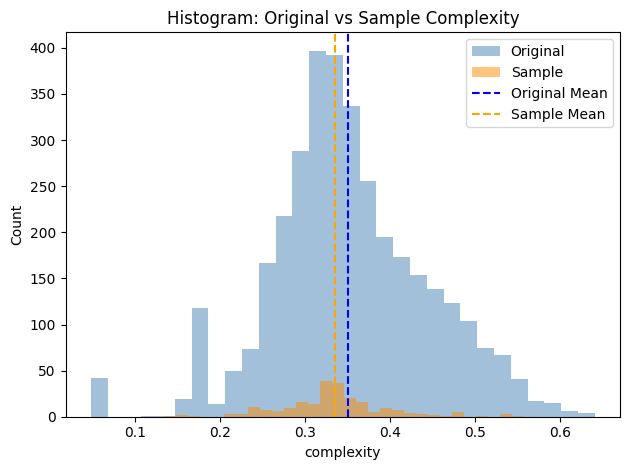

In [92]:
import matplotlib.pyplot as plt

plt.hist(full_keep['complexity'], bins=30, alpha=0.5, label='Original', color='steelblue')
plt.hist(selected['complexity'], bins=30, alpha=0.5, label='Sample', color='darkorange')
plt.axvline(full_keep['complexity'].mean(), color='blue', linestyle='--', label='Original Mean')
plt.axvline(selected['complexity'].mean(), color='orange', linestyle='--', label='Sample Mean')
plt.xlabel('complexity')
plt.ylabel('Count')
plt.title('Histogram: Original vs Sample Complexity')
plt.legend()
plt.tight_layout()
plt.show()


In [33]:
'''
import matplotlib.pyplot as plt 
plt.figure(figsize=(8, 6))
plt.hist(full_keep['complexity'], bins=30, alpha=0.5,
         label='Original', density=True, edgecolor='black')
plt.hist(selected['complexity'], bins=30, alpha=0.5,
         label='Selected Sample', density=True, edgecolor='black')
plt.axvline(full_keep['complexity'].mean(),
            color='blue', linestyle='--', label='Original Mean')
plt.axvline(selected['complexity'].mean(),
            color='orange', linestyle='--', label='Sample Mean')
plt.legend()
plt.title("Score Distribution: Original vs Selected Sample")
plt.xlabel("Graph Difficulty Score")
plt.ylabel("Density")
plt.grid(True, linestyle=':', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()
'''

'\nimport matplotlib.pyplot as plt \nplt.figure(figsize=(8, 6))\nplt.hist(full_keep[\'complexity\'], bins=30, alpha=0.5,\n         label=\'Original\', density=True, edgecolor=\'black\')\nplt.hist(selected[\'complexity\'], bins=30, alpha=0.5,\n         label=\'Selected Sample\', density=True, edgecolor=\'black\')\nplt.axvline(full_keep[\'complexity\'].mean(),\n            color=\'blue\', linestyle=\'--\', label=\'Original Mean\')\nplt.axvline(selected[\'complexity\'].mean(),\n            color=\'orange\', linestyle=\'--\', label=\'Sample Mean\')\nplt.legend()\nplt.title("Score Distribution: Original vs Selected Sample")\nplt.xlabel("Graph Difficulty Score")\nplt.ylabel("Density")\nplt.grid(True, linestyle=\':\', linewidth=0.5, alpha=0.6)\nplt.tight_layout()\nplt.show()\n'